In [26]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

from dotenv import load_dotenv
import os
load_dotenv()

if os.environ['OPENAI_API_KEY']:
    print("OpenAI API Key is set.")
else:
    raise ValueError("OpenAI API Key is not set.")

OpenAI API Key is set.


In [27]:
llm = ChatOpenAI(model="gpt-5-nano")

### **Pydantic LLM Schema** 

In [28]:
from pydantic import BaseModel, Field
from typing import List, TypedDict

class llm_schema(BaseModel):
    tasks: List[str] = Field(..., description="A list of tasks to be performed by the worker.")

llm_with_schema = llm.with_structured_output(llm_schema)

### **Graph Schema**

In [29]:
class graph_schema(TypedDict):

    tasks: List[str]
    query: str
    results: List[str]
    summary: str

### **Creating Orchestrator Node**

In [30]:
def orchestrator_node(state: graph_schema) -> graph_schema:

    # Fetching the user query from the state
    user_query = state['query']

    # Create the prompt for the LLM
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are an orchestrator that breaks down a user query into tasks for the worker."),
            ("user", f"User query: {user_query}. Please generate one prompt per task for the worker to complete. Return the tasks in a list format."),
        ]
    )

    # Create the chain
    chain = prompt | llm_with_schema

    # Run the chain with the user query as input
    response = chain.invoke({"query": user_query})


    # Update the state with the generated tasks
    state['tasks'] = response.tasks

    return state


### **Worker Node**

In [31]:
# Execute Function

def execute(query:str) :

    response = llm.invoke(f"Please execute this task {query}")
    return response.content

In [32]:
from concurrent.futures import ThreadPoolExecutor

def worker_node(state: graph_schema) -> graph_schema:

    tasks = state['tasks']
    results = []

    with ThreadPoolExecutor(max_workers=len(tasks)) as executor:

        results_futures = executor.map(execute, tasks)
        for result in results_futures:
            results.append(result)
    
    state['results'] = results
    
    return state

### **Collector Node**

In [ ]:
def collector_node(state: graph_schema):

    results = state['results']

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a collector that summarizes the results from the worker."),
            ("user", f"Here are the results from the worker: {results}. Please summarize these results in a concise manner."),
        ]
    )

    chain = prompt | llm

    summary = chain.invoke({"results": results})

    state['summary'] = summary.content

    return state

### **Creating Graph and Executing**

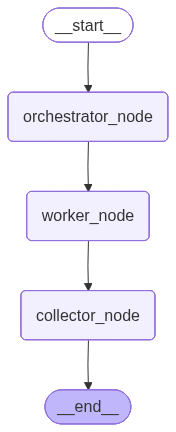

In [34]:
from langgraph.graph import StateGraph, START, END


graph = StateGraph(graph_schema)

graph.add_node("orchestrator_node",orchestrator_node)
graph.add_node("worker_node",worker_node)
graph.add_node("collector_node",collector_node)

graph.add_edge(START, "orchestrator_node")
graph.add_edge("orchestrator_node", "worker_node")
graph.add_edge("worker_node", "collector_node")
graph.add_edge("collector_node", END)

complex_graph = graph.compile()

from IPython.display import Image, display

# You could see the errors with the below command
Image(complex_graph.get_graph().draw_mermaid_png())

In [35]:
complex_graph.invoke(
    {
        "query": "What is the capital of France and what is the population of Paris? & What is the capital of Germany and what is the population of Berlin?",
        "tasks": [],
        "results": [],
        "summary": "",
    }
)

{'tasks': ['Provide the capital of France.',
  'Provide the population of Paris (city proper) as of the latest available data.',
  'Provide the capital of Germany.',
  'Provide the population of Berlin (city proper) as of the latest available data.'],
 'query': 'What is the capital of France and what is the population of Paris? & What is the capital of Germany and what is the population of Berlin?',
 'results': ['Paris.',
  '- Paris (city proper) population: 2,161,000 inhabitants (1 January 2020), per INSEE.\n\nNote:\n- This figure is for the city proper (the commune of Paris), not the larger Paris metropolitan area, which has about 12 million people.\n- If you want the very latest year’s official figure, I can look up the most recent INSEE data (they publish population municipale annually).',
  'Berlin',
  'Berlin (city proper) population: 3,769,495 as of 31 December 2022.\n\nSource: Destatis (Federal Statistical Office) / Amt für Statistik Berlin-Brandenburg – Population of municipal

In [36]:
for chunk in complex_graph.stream(
    {
        "query": "What is the capital of France and what is the population of Paris? & What is the capital of Germany and what is the population of Berlin?",
        "tasks": [],
        "results": [],
        "summary": "",
    },
    stream_mode="updates"
):
    print(chunk)

{'orchestrator_node': {'tasks': ["Prompt: What is the capital city of France? Respond with only the city name (e.g., 'Paris').", 'Prompt: What is the population of Paris? Respond with the population number only, using the latest available city-proper estimate.', "Prompt: What is the capital city of Germany? Respond with only the city name (e.g., 'Berlin').", 'Prompt: What is the population of Berlin? Respond with the population number only, using the latest available city-proper estimate.'], 'query': 'What is the capital of France and what is the population of Paris? & What is the capital of Germany and what is the population of Berlin?', 'results': [], 'summary': ''}}
{'worker_node': {'tasks': ["Prompt: What is the capital city of France? Respond with only the city name (e.g., 'Paris').", 'Prompt: What is the population of Paris? Respond with the population number only, using the latest available city-proper estimate.', "Prompt: What is the capital city of Germany? Respond with only t